In [ ]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import jaccard_score, f1_score, log_loss, precision_score, accuracy_score, recall_score

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries Imported.")

Libraries Imported.


In [ ]:
#load the csv file into a new pandas dataframe
ticket_df = pd.read_csv('Train Data1.csv', header = 0)
print(ticket_df.shape)
ticket_df.head()

(1470, 2)


,Issues,Categories
0,"Unable to process Row No ""1"". Received Mfr. Se...",Validation Error
1,User does not have the permission to Perform t...,Validation Error
2,"Contract # ""SCNT48034"" Revision # ""0"" cannot b...",Validation Error
3,"Unable to process Material Request. Serial # ""...",Validation Error
4,The State Code entered already exists for the ...,Validation Error


In [ ]:
ticket_df['Categories'].value_counts()

Validation Error    1309
Database Error        55
Scripting Error       51
Others                23
Product error         13
Deployment Error      10
Server Error           7
Framework error        2
Name: Categories, dtype: int64

In [ ]:
classifier = 'Categories'
classifier_labels = list(ticket_df[classifier].value_counts().index)
classifier_labels

['Validation Error',
 'Database Error',
 'Scripting Error',
 'Others',
 'Product error',
 'Deployment Error',
 'Server Error',
 'Framework error']

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from spacy.lang.en import English
import string
from collections import Counter
import spacy
import re

In [ ]:
parser = English()
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

import nltk
nltk.download('stopwords')
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + ["hi"])
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "…", """, """]

# Function to cleanup the text in increments
def cleanup_text(docs, logging=False):
  texts = []
  counter = 1
  for doc in docs:
    if counter % 1000 == 0 and logging:
      print("Processed %d out of %d documents." % (counter, len(docs)))
    
    counter += 1

    doc = re.sub(r'\d+', '', doc)
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in SYMBOLS]
    tokens = ' '.join(tokens)
    texts.append(tokens)
      
  print("Processed %d out of %d documents." % (len(docs), len(docs)))
  return pd.Series(texts)

# Function to find common words for each defined category
def find_common_words_by_category(categories, N):
  for category in categories:
    category_text = [text for text in ticket_df[ticket_df['ticket_type'] == category]['Issues']]
    cleanup_category_text = cleanup_text(category_text, True)
    cleanup_category_text = ' '.join(cleanup_category_text).split()
    category_counter = Counter(cleanup_category_text)

    common_words_by_category = [word[0] for word in category_counter.most_common(N)]
    word_count_by_category = [word[1] for word in category_counter.most_common(N)]
    
    word_statement = f"{category} has {word_count_by_category} words : {common_words_by_category}"
    print(word_statement)
    print()
    
# find_common_words_by_category(classifier_labels, 10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

ticket_df['ticket_type_id'] = ticket_df['Categories'].factorize()[0]

In [ ]:
ticket_type_id_df = ticket_df[['Categories', 'ticket_type_id']].drop_duplicates().sort_values('ticket_type_id')
ticket_type_to_id = dict(ticket_type_id_df.values)
id_to_ticket_type = dict(ticket_type_id_df[['ticket_type_id', 'Categories']].values)
ticket_df.head()

,Issues,Categories,ticket_type_id
0,"Unable to process Row No ""1"". Received Mfr. Se...",Validation Error,0
1,User does not have the permission to Perform t...,Validation Error,0
2,"Contract # ""SCNT48034"" Revision # ""0"" cannot b...",Validation Error,0
3,"Unable to process Material Request. Serial # ""...",Validation Error,0
4,The State Code entered already exists for the ...,Validation Error,0


In [ ]:
print(ticket_type_to_id)

{'Validation Error': 0, 'Others': 1, 'Database Error': 2, 'Product error': 3, 'Scripting Error': 4, 'Framework error': 5, 'Deployment Error': 6, 'Server Error': 7}


In [ ]:
X = ticket_df['Issues'].values
y = ticket_df['Categories'].values

In [ ]:
print(y)

['Validation Error' 'Validation Error' 'Validation Error' ...
 'Scripting Error' 'Validation Error' 'Product error']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X)
labels = ticket_df['ticket_type_id']
features.shape


(1470, 776)

In [ ]:
parser = English()
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + ["hi"])
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "…", """, """]

counter = 1 
total = len(X)
for idx, item in enumerate(X):
    if counter % 2500 == 0:
      print("Processed %d out of %d documents." % (counter, total))

    counter += 1 
    item = re.sub(r'\d+', '', item)
    item = nlp(item, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in item if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in SYMBOLS]
    tokens = ' '.join(tokens)
    X[idx] = tokens

print("Processed %d out of %d documents." % (total, total))

X[0:5]

Processed 1470 out of 1470 documents.


array(['unable process row receive mfr serial  ta srl  available stock enter unique serial',
       'user permission perform document invoice itm-- modify user refresh',
       'contract scnt revision confirm information provide complete visit contract upload summary page know',
       'unable process material request serial mvh available warehouse ta- warning null value eliminate aggregate set operation',
       'state code enter exist country enter unique state code'],
      dtype=object)

In [ ]:
print(X)

['unable process row receive mfr serial  ta srl  available stock enter unique serial'
 'user permission perform document invoice itm-- modify user refresh'
 'contract scnt revision confirm information provide complete visit contract upload summary page know'
 ... '.\\files\\controlsheets\\r&b db-_contorl.xlsx excel workbook exist'
 'cost center map account code context component adepp ou ramcoou bu avbu fb aveos docno dep-- trantype fa_adpr actcode- costcenter-'
 'finance postings error']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X)
labels = ticket_df['ticket_type_id']
features.shape

(1470, 758)

In [ ]:
print(ticket_type_to_id.items());
print(sorted([('Validation Error', 0), ('Others', 1), ('Database Error', 2), ('Product error', 3), ('Scripting error', 4), ('Framework error', 5), ('Deployment Error', 6), ('Server Error', 7)]));

dict_items([('Validation Error', 0), ('Others', 1), ('Database Error', 2), ('Product error', 3), ('Scripting Error', 4), ('Framework error', 5), ('Deployment Error', 6), ('Server Error', 7)])
[('Database Error', 2), ('Deployment Error', 6), ('Framework error', 5), ('Others', 1), ('Product error', 3), ('Scripting error', 4), ('Server Error', 7), ('Validation Error', 0)]


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
X_counts = tfidf.fit_transform(X)
# tfidf_transformer = TfidfTransformer()
# X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_counts.shape 

(1470, 758)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size = 0.3, shuffle=True, stratify=y, random_state = 42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1029, 758) (1029,)
Test set: (441, 758) (441,)


Multinomial Classification Algorithm with Supervised Machine Learning and NLP¶


In [ ]:

from sklearn.svm import LinearSVC

model_dict = {
              
              'Linear Support Vector Classifier': LinearSVC()
             }

model_dict

{'Linear Support Vector Classifier': LinearSVC()}

In [ ]:
def model_score_df(model_dict):
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []

    X_train.todense();
    X_test.todense();
    for k, v in model_dict.items():
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        print(model_comparison_df)

    return model_comparison_df

In [ ]:
def execute_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy   : ", accuracy_score(y_test, y_pred))
    print("Precision  : ", precision_score(y_test, y_pred, average='macro'))
    print("Recall     : ", recall_score(y_test, y_pred, average='macro'))
    print("F1         : ", f1_score(y_test, y_pred, average='macro'))

    labels = ["Validation Error", "Database Error", "Others", "Scripting Error", "Framework error", "Deployment Error", "Server Error"]


    matrix = confusion_matrix(y_test, y_pred, labels = labels)
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(matrix, annot=True, fmt='d', cmap = "Blues", xticklabels=labels, yticklabels=labels)
    ax.set_title("Confusion Matrix", fontsize=18)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)

Linear Suuport Vector Classifier: 

Accuracy   :  0.9727891156462585
Precision  :  0.685
Recall     :  0.6330896719374772
F1         :  0.6561757537732665


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


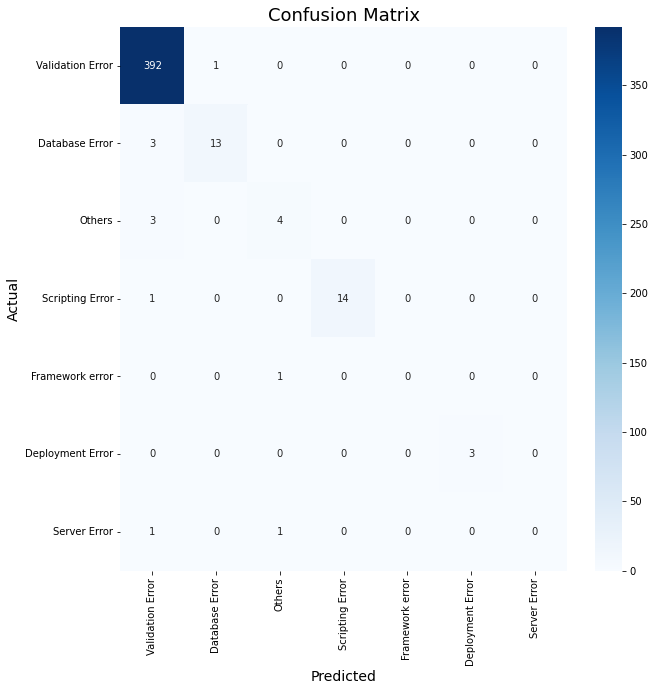

In [ ]:
print('Linear Suuport Vector Classifier: \n')
model = LinearSVC()
execute_model(model)

In [ ]:
model = LinearSVC(random_state=0, tol=1e-05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy   : ", accuracy_score(y_test, y_pred))
print("Precision  : ", precision_score(y_test, y_pred, average='macro'))
print("Recall     : ", recall_score(y_test, y_pred, average='macro'))
print("F1         : ", f1_score(y_test, y_pred, average='macro'))

Accuracy   :  0.9727891156462585
Precision  :  0.685
Recall     :  0.6330896719374772
F1         :  0.6561757537732665


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
